In [1]:
import ingestor, modeller, fitter
import numpy as np
from matplotlib import pyplot as plt

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
from importlib import reload

reload(ingestor)
reload(modeller)
reload(fitter)

<module 'fitter' from '/media/dwu402/Data/wrap-mad/fitter.py'>

In [4]:
context = ingestor.initialise_context()
ingestor.read_run_file(context, "runs/mouse4.3.run")

In [5]:
model = modeller.Model(context)

In [6]:
solver = fitter.Fitter()
solver.construct_objectives(context, model)

In [7]:
solver.construct_problems()
print(solver.solutions)

{}


In [8]:
for rhoi in np.logspace(1, 5, num=41):
    solver.solve(rhoi)

In [9]:
solver.solutions

{'10.0': [      fun: 0.11659342994557494
   hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
        jac: array([ 0.0016526 ,  0.00049605,  0.00521841,  0.00294731, -0.005592  ,
         -0.00252685,  0.00212057, -0.00043477,  0.05141717])
    message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
       nfev: 188
        nit: 123
     status: 0
    success: True
          x: array([ 0.        ,  0.        ,  0.        , 91.84004789, 48.38994169,
         11.39322897, 13.62398031,  2.82618728,  0.        ])],
 '12.589254117941675': [      fun: 0.12689545937070779
   hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
        jac: array([ 1.62262212e-04,  5.72517405e-04,  9.12655476e-06, -2.70050049e-07,
         -4.32936762e-06,  2.03886496e-06, -6.54391719e-06,  1.13277878e-05,
          1.24321181e-02])
    message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
       nfev: 107
        nit: 78
     status: 0
    success: True
          x: array([0.00000000e+00, 0.0

## Validation

In [10]:
## Validation of the outer jacobian
ca = fitter.ca
dHdc = ca.hcat([ca.gradient(solver._inner_objective._obj_1, ci) for ci in model.cs]).reshape((1, 3*model.K))
d2Jdc2 = ca.hcat([ca.jacobian(solver._inner_objective.inner_jacobian, ci) for ci in model.cs]).reshape((3*model.K, 3*model.K))
dJ2dcdp = ca.hcat([ca.jacobian(solver._inner_objective.inner_jacobian, pi) for pi in model.ps]).reshape((3*model.K, len(model.ps)))

In [11]:
dHdc_fn = ca.Function("dhdcfn", solver._inner_objective.input_list, [dHdc])
d2Jdc2_fn = ca.Function("d2jdc2", solver._inner_objective.input_list, [d2Jdc2])
dJ2dcdp_fn = ca.Function("d2jdcdp", solver._inner_objective.input_list, [dJ2dcdp])

In [12]:
in_arg = [model.observation_times, *fitter.argsplit(solver.problems[0].cache.recent, 3), *[0.3, 1, 0.7, 2, 1, 1, 1, 1, 0], solver._inner_objective.generate_collocation_matrix(context['datasets'][0], model), len(context['datasets'][0]['t']), *solver._inner_objective.pad_observations(context['datasets'][0]['y']), 1000]

In [13]:
dhdc_eval = dHdc_fn(*in_arg)
d2jdc2_eval = d2Jdc2_fn(*in_arg)
dj2dcdp_eval = dJ2dcdp_fn(*in_arg)

In [14]:
import numpy as np
def numerical_log(matrix):
    return np.log(np.fabs(np.array(matrix))+1e-16)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

Text(0.5, 1.0, 'log(dH/dc)')

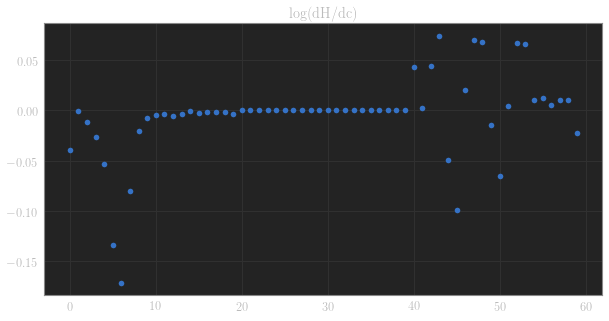

In [15]:
plt.plot(np.array(dhdc_eval).reshape(-1,), 'o')
plt.title("log(dH/dc)")

Text(0.5, 1.0, 'log(d2J/dc2)')

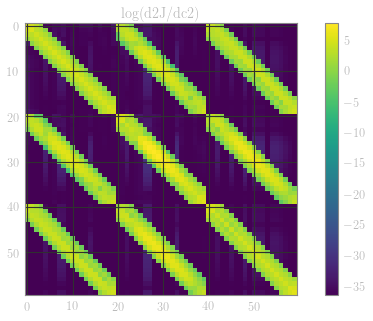

In [16]:
plt.imshow(numerical_log(d2jdc2_eval))
plt.colorbar()
plt.title("log(d2J/dc2)")

Text(0.5, 1.0, 'log(dJ2dcdp)')

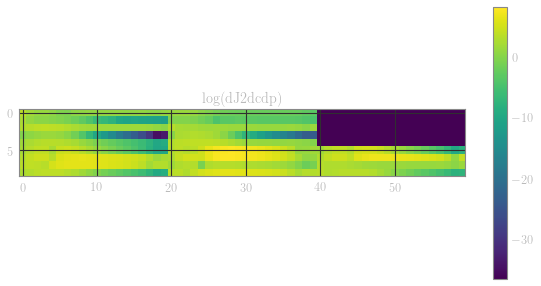

In [17]:
plt.imshow(numerical_log(dj2dcdp_eval).T)
plt.colorbar()
plt.title("log(dJ2dcdp)")

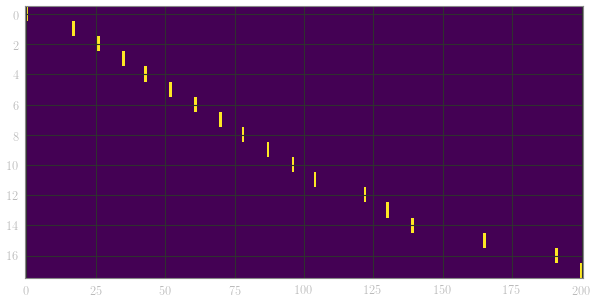

In [18]:
H_num = solver._inner_objective.generate_collocation_matrix(context['datasets'][0], model)
plt.imshow(H_num, aspect='auto')

In [19]:
# create and profile calls

obj_fn, obj_jac = solver._inner_objective.create_objective_functions(model, context['datasets'][0])

c_test = np.array(solver.problems[0].cache.recent)

%timeit obj_fn(c_test, [0.3, 1, 0.7, 2, 1, 1, 1,1 , 1e-4], rho=1000)

34.3 ms ± 87.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
getx = ca.Function("getx", [model.ts, *model.cs], model.xs)

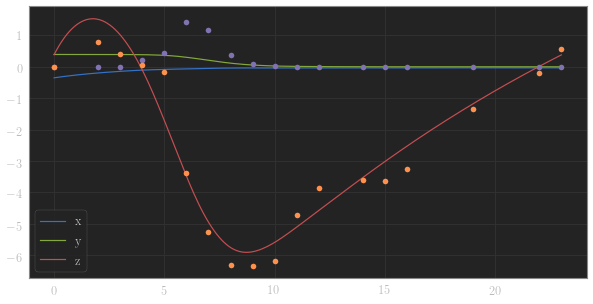

In [42]:
xs = np.array([np.array(i) for i in getx(model.observation_times, *fitter.argsplit(solver.problems[0].cache.recent, 3))])
plt.plot(model.observation_times, np.hstack([xs[0], xs[1], xs[2]]),
         context['datasets'][0]['t'], context['datasets'][0]['x'], 'o',
         context['datasets'][0]['t'], context['datasets'][0]['z'], 'o')
plt.legend("xyz")

iv = [xs[i][0].item() for i in range(3)]

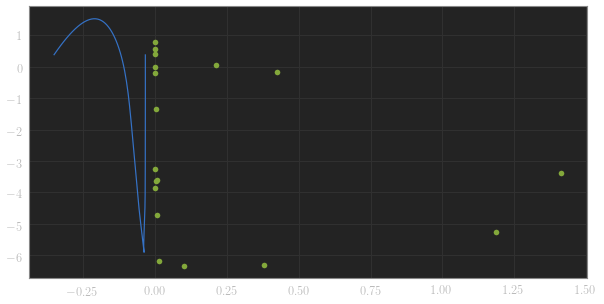

In [32]:
plt.plot(xs[0], xs[2], context['datasets'][0]['x'], context['datasets'][0]['z'], 'o')

In [43]:
print(context['datasets'][0]['y'][:5])

0                                [3.48e-05, 0.0]
1              [0.001162611, 0.7800000000000002]
2             [0.001478414, 0.41999999999999993]
3             [0.212730337, 0.07000000000000028]
4    [0.42600703700000003, -0.16999999999999993]
Name: y, dtype: object


In [22]:
from scipy import integrate

sol = integrate.solve_ivp(lambda t, y: context['model'](t, y, [0.92255063, 0.55098101, 1.97517646, 0.45065379, 0.66048963,
         2.21360157, 2.85341497, 1.13601111, 0.55253756]), [0, 24], iv)

sol.y[2]

array([3.85342469e-01, 3.38503226e-01, 2.34002644e-01, 2.53160352e-01,
       3.39436852e-01, 4.00043151e-01, 4.40658369e-01, 4.90852784e-01,
       4.98479582e-01, 5.30750775e-01, 5.70088870e-01, 5.83474294e-01,
       6.46924058e-01, 7.02786516e-01, 8.68126739e-01, 8.93082470e-01,
       9.77807810e-01, 1.06132593e+00, 1.17267463e+00, 1.19303228e+00,
       1.20622748e+00, 1.23523702e+00, 1.26081587e+00, 1.26457464e+00,
       1.28595832e+00, 1.30243719e+00, 1.31543243e+00, 1.32466687e+00,
       1.34275783e+00, 1.36403777e+00, 1.38544977e+00, 1.40985114e+00,
       1.45740359e+00, 1.49191189e+00, 1.55587650e+00, 1.62297708e+00,
       1.66173775e+00, 1.73268022e+00, 1.81420875e+00, 1.91495101e+00,
       2.02242843e+00, 2.55109590e+00, 2.71421588e+00, 2.74464146e+00,
       2.76589526e+00, 2.78715780e+00, 2.79942326e+00, 2.85068151e+00,
       2.89182004e+00, 2.94044091e+00, 2.96578994e+00, 3.05170372e+00,
       3.11682541e+00, 3.39394885e+00, 3.66410671e+00, 6.50540313e+00,
      

In [23]:
outer_evals = {r:v[0].fun for r, v in solver.solutions.items()}

outer_list = np.array([[float(key), value] for key, value in outer_evals.items()])

Text(0.5, 1.0, "'L'-Curve")

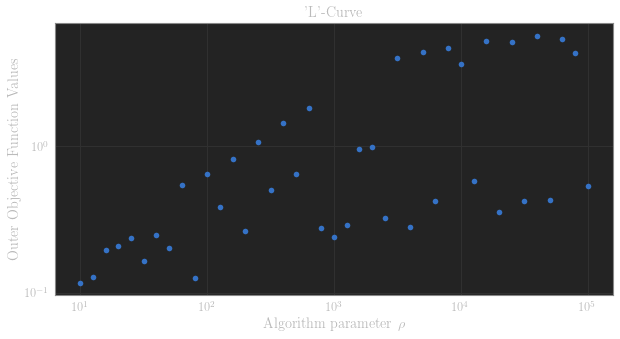

In [24]:
plt.loglog(*outer_list.T, 'o')
plt.xlabel(r"Algorithm parameter $\rho$ ")
plt.ylabel(r"Outer Objective Function Values")
plt.title("'L'-Curve")

In [25]:
def gen_key(sol_key, solution):
    return "y".join(map(str,solution.x)) + "r" + sol_key

In [26]:
inner_evals = dict()
for soli in solver.solutions:
    key = gen_key(soli, solver.solutions[soli][0])
    inner_evals[soli] = solver.problems[0].cache.results[key]
    

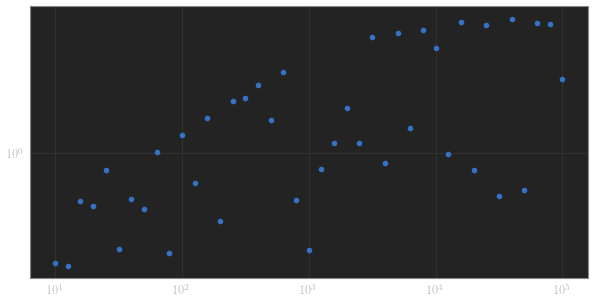

In [27]:
new_list = []
for key in inner_evals.keys():
    new_list.append((float(key), inner_evals[key].fun))
new_list = np.array(new_list)
plt.loglog(*np.array(new_list).T, 'o')

In [28]:
diff_field_value = [[okey, (ivalue-ovalue)/(ikey)] for (ikey, ivalue), (okey, ovalue) in zip(new_list, outer_list)]

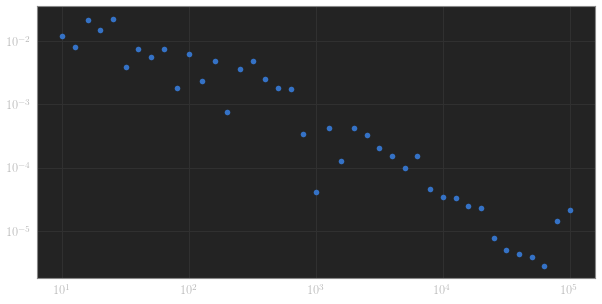

In [29]:
plt.loglog(*np.array(diff_field_value).T, 'o')